# Balanced Dataset: Sentinel-2 (all bands) + Sentinel-1 

In the first part of the notebook, we calculate errors (MSE, MAE, R2-score) with various classical methods: 

- Linear regression
- Random Forest 
- Optimized LR and RF with Grid Search 

Results obtained (prior to optimization): 

###### Linear Regression (Sentinel-2 + Sentinel-1):
- Mean Squared Error: 6.88   (with Grid Search 6.88) 
- Mean Absolute Error: 2.22
- R-squared: 0.13               (with Grid Search 0.13)

###### Random Forest (Sentinel-2 + Sentinel-1):
- Mean Squared Error: 6.37       (with Grid Search 6.35)
- Mean Absolute Error: 2.08
- R-squared: 0.19                (with Grid Search 0.19)


In the second part of the dataset I enrich the dataset with extra features (various indices related to Sentinel-1 and Sentinel-2). I recalculate the classical errors (LR, RF, LR and RF optimized with Grid Search), also PCA and REF. 

The best results for Random Forest found so far are the following: 
###### Random Forest (All Sentinels + All Indices + REF): 
- Mean squared error: 6.32    (after Grid Search 6.26) 
- Mean absolute error: 2.07   (after Grid Search 2.07)
- R2 score: 0.19              (after Grid Search 0.19489)

## Attempt 1: Enriched Dataset: Sentinel-2 + Sentinel-1 + Indices related to Sentinel-1 
We notice that Linear Regression errors (MSE, MAE) go slightly down, while the Random Forest errors (MSE, MAE) go slightly up. 

##### Linear Regression (Sentinel-2 + Sentinel-1 + Indices-1):
- Mean Squared Error: 6.82          
- Mean Absolute Error: 2.20
- R-squared: 0.13

##### Random Forest (Sentinel-2 + Sentinel-1 + Indices-1):
- Mean Squared Error: 6.40
- Mean Absolute Error: 2.09
- R-squared: 0.19

## Attempt 2: Enriched Dataset: Sentinel-2 + Sentinel-1 + Indices-1 + Indices of Sentinel-2 

##### Linear Regression (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):
- Mean Squared Error: 6.82       (with Grid Search: 6.81)
- Mean Absolute Error: 2.20      (with Grid Search: same)
- R-squared: 0.13                (with Grid Search: same) 

##### Random Forest (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):
- Mean Squared Error: 6.39       (with Grid Search 6.35) 
- Mean Absolute Error: 2.08      (with Grid Search 2.09) 
- R-squared: 0.19                (with Grid Search 0.19) 

### PCA on  the enriched dataset Sentinel-2 + Sentinel-1 + Indices-1 + Indices-2 

I run PCA on this dataset (X_rich) and calculated the error on the dataset (X_pca) obtained after PCA:  

##### Linear Regression (All Sentinels + All Indices + PCA):
- Mean Squared Error: 6.92
- Mean Absolute Error: 2.23
- R-squared: 0.12

##### Random Forest (All Sentinels + All Indices + PCA):
- Mean Squared Error: 6.59
- Mean Absolute Error: 2.13
- R-squared: 0.16

### REF on  the enriched dataset Sentinel-2 + Sentinel-1 + Indices-1 + Indices-2  (Lowest error found)

I run REF on X_rich_S2 and calculated the error on the new dataset X_ref. Here's the most important features ranked (1 = most important):
- Sentinel-2 B2: 1
- Sentinel-2 B3: 5
- Sentinel-2 B4: 3
- Sentinel-2 B5: 8
- Sentinel-2 B6: 4
- Sentinel-2 B7: 1
- Sentinel-2 B8: 1
- Sentinel-2 B11: 6
- Sentinel-2 B12: 1
- Sentinel-1 VV: 12
- Sentinel-1 VH: 7
- sigma_VV: 9
- sigma_VH: 11
- VH/VV: 2
- NDVI(VH|VV): 1
- UAI(VH|VV): 1
- NDVI(Sent-2): 10
- NDBI: 1
- NDWI: 1
- NDSI: 1
- UAI(Sent-2): 1
 

##### Random Forest (All Sentinels + All Indices + REF): 
- Mean squared error: 6.32    (after Grid Search 6.26) 
- Mean absolute error: 2.07   (after Grid Search 2.07)
- R2 score: 0.19              (after Grid Search 0.19489)


In [24]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from PIL import Image
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [25]:
data = np.load('balanced.npy')

# load the numpy array into a pandas dataframe
df = pd.DataFrame(data)

df.head()
df.describe()

# extract the last column as a numpy array
y = df.iloc[:, -1].values
print('Here is the shape of y', y.shape)

# extract all other columns as a numpy array
X = df.iloc[:, :-1].values

# print the shape of the new X array
print('Here is the shape of X:', X.shape)

Here is the shape of y (89249,)
Here is the shape of X: (89249, 11)


In [26]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,83.0,107.0,119.0,128.0,140.0,155.0,155.0,226.0,207.0,192.0,99.0,5.438804
1,116.0,121.0,138.0,145.0,159.0,143.0,141.0,213.0,223.0,180.0,134.0,8.852391
2,73.0,95.0,96.0,103.0,131.0,124.0,143.0,136.0,116.0,164.0,112.0,6.947169
3,24.0,42.0,37.0,74.0,163.0,184.0,199.0,157.0,93.0,158.0,92.0,7.556633
4,56.0,78.0,127.0,136.0,169.0,181.0,202.0,225.0,202.0,95.0,66.0,5.445318


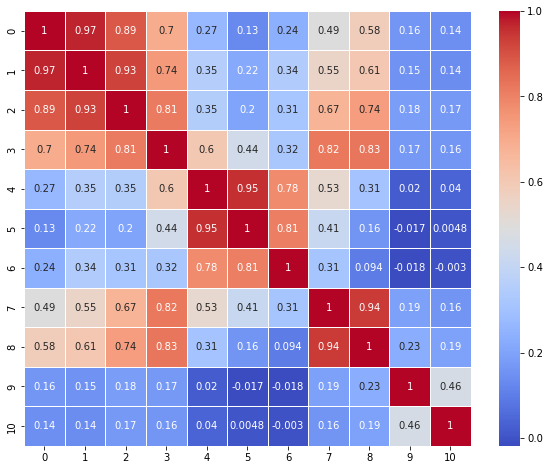

In [27]:
### Visualize correlations between columns of X 
import seaborn as sns
# create a correlation matrix
corr_matrix = np.corrcoef(X, rowvar=False)

# create a larger plot
fig, ax = plt.subplots(figsize=(10, 8))

# create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)

# show plot
plt.show()

In [28]:
##### Runs various models on X and y prepared above 

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# scale X using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Train the models on the training data
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_gb = gb.predict(X_test)

# Evaluate the models using mean squared error and R-squared
print("Linear Regression (Sentinel-2 + Sentinel-1):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_lr)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test, y_pred_lr)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_lr)))
print()

print("Decision Tree (Sentinel-2 + Sentinel-1):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_dt)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test, y_pred_dt)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_dt)))
print()

print("Random Forest (Sentinel-2 + Sentinel-1):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_rf)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test, y_pred_rf)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_rf)))
print()

print("Gradient Boosting (Sentinel-2 + Sentinel-1):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_gb)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test, y_pred_gb)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_gb)))
print()


Linear Regression (Sentinel-2 + Sentinel-1):
Mean Squared Error: 6.88
Mean Absolute Error: 2.22
R-squared: 0.13

Decision Tree (Sentinel-2 + Sentinel-1):
Mean Squared Error: 12.79
Mean Absolute Error: 2.80
R-squared: -0.62

Random Forest (Sentinel-2 + Sentinel-1):
Mean Squared Error: 6.37
Mean Absolute Error: 2.08
R-squared: 0.19

Gradient Boosting (Sentinel-2 + Sentinel-1):
Mean Squared Error: 6.46
Mean Absolute Error: 2.12
R-squared: 0.18



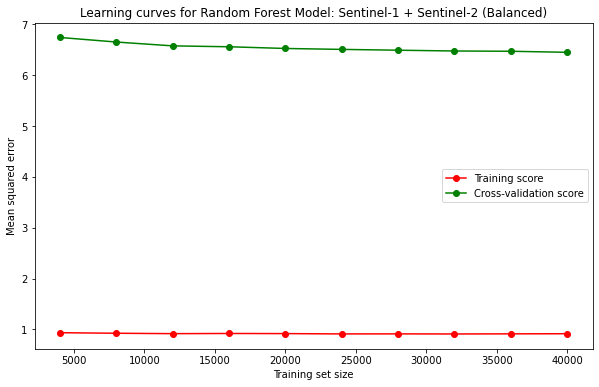

In [15]:
#### LESS DATA IN INPUT !!! 10000 rows 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples
subset_idx = np.random.choice(len(X), size= 50000, replace=False)
X__subset = X[subset_idx]
y__subset = y[subset_idx]

# Create an instance of the Random Forest model
rf__model = RandomForestRegressor()

# Define the range of training set sizes to use
train__sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Random Forest model
train__sizes, train__scores, test__scores = learning_curve(rf__model, X__subset, y__subset, cv=5, train_sizes=train__sizes, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train__scores = -train__scores
test__scores = -test__scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train__scores_mean = np.mean(train__scores, axis=1)
train__scores_std = np.std(train__scores, axis=1)
test__scores_mean = np.mean(test__scores, axis=1)
test__scores_std = np.std(test__scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train__sizes, train__scores_mean, 'o-', color='r', label='Training score')
plt.plot(train__sizes, test__scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model: Sentinel-1 + Sentinel-2 (Balanced)')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()

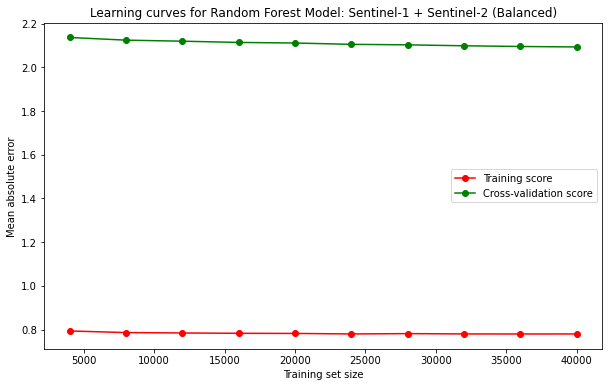

In [29]:
#### LESS DATA IN INPUT : Learning curve for mae

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples
subset_idx = np.random.choice(len(X), size= 50000, replace=False)
X__subset = X[subset_idx]
y__subset = y[subset_idx]

# Create an instance of the Random Forest model
rf__model = RandomForestRegressor()

# Define the range of training set sizes to use
train__sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Random Forest model
train__sizes, train__scores, test__scores = learning_curve(rf__model, X__subset, y__subset, cv=5, train_sizes=train__sizes, scoring='neg_mean_absolute_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train__scores = -train__scores
test__scores = -test__scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train__scores_mean = np.mean(train__scores, axis=1)
train__scores_std = np.std(train__scores, axis=1)
test__scores_mean = np.mean(test__scores, axis=1)
test__scores_std = np.std(test__scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train__sizes, train__scores_mean, 'o-', color='r', label='Training score')
plt.plot(train__sizes, test__scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model: Sentinel-1 + Sentinel-2 (Balanced)')
plt.xlabel('Training set size')
plt.ylabel('Mean absolute error')
plt.legend(loc='best')
plt.show()

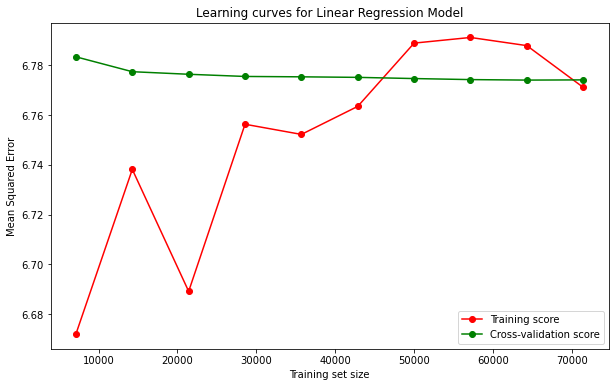

In [16]:
### Learning Curve for the regression model 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

# Create an instance of the Linear Regression model
lr_model = LinearRegression()

# Define the range of training set sizes to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Linear Regression model
train_sizes, train_scores, test_scores = learning_curve(lr_model, X, y, cv=5, train_sizes=train_sizes, scoring='neg_mean_squared_error')

# Convert the negative mean squared error scores to positive
train_scores = -train_scores
test_scores = -test_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning curves for Linear Regression Model')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.show()


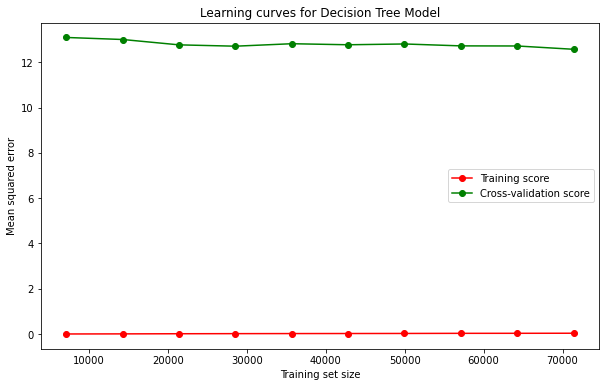

In [17]:
# Learning curve for the Decision Tree model 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve

# Convert y to a 1d array using ravel()
y = np.ravel(y)

# Create an instance of the Decision Tree model
tree_model = DecisionTreeRegressor()

# Define the range of training set sizes to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Decision Tree model
train_sizes, train_scores, test_scores = learning_curve(tree_model, X, y, cv=5, train_sizes=train_sizes, scoring='neg_mean_squared_error')

# Convert the negative mean squared error scores to positive
train_scores = -train_scores
test_scores = -test_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning curves for Decision Tree Model')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()


In [17]:
## Grid Search on Linear Regression and Random Forest 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameters and their possible values for Linear Regression and Random Forest
hyperparameters = {
    'LinearRegression': {'normalize': [True, False]},
    'RandomForestRegressor': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
}

# Create a dictionary of the models to be tuned
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

# Loop through the models and their hyperparameters to perform grid search
for model_name, model in models.items():
    hyperparameter_grid = hyperparameters[model_name]
    grid_search = GridSearchCV(model, hyperparameter_grid, cv=5, verbose=2)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(model_name, "best hyperparameters:", grid_search.best_params_, "MSE:", mse, "R-squared:", r2)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
LinearRegression best hyperparameters: {'normalize': True} MSE: 6.8816318394633775 R-squared: 0.12654859641295668
Fitting 5 folds 

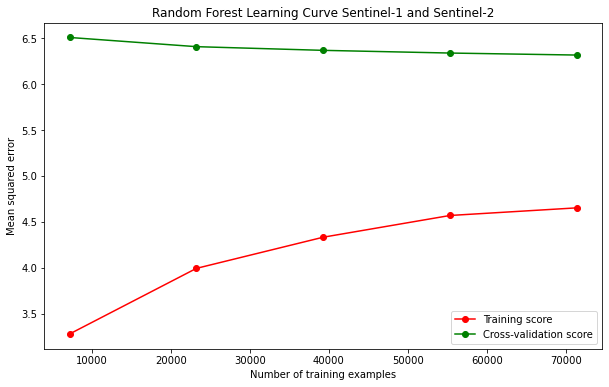

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the best hyperparameters
params = {'max_depth': 15, 'n_estimators': 300}

# Create an instance of the Random Forest model with the best hyperparameters
rf_model = RandomForestRegressor(**params)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Number of training examples')
plt.ylabel('Mean squared error')
plt.title('Random Forest Learning Curve Sentinel-1 and Sentinel-2') 
plt.legend()
plt.show()


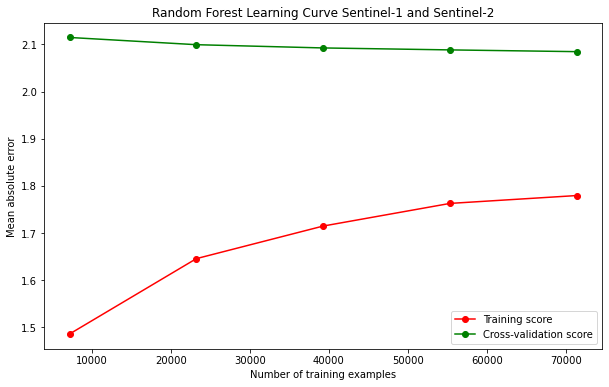

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the best hyperparameters
params = {'max_depth': 15, 'n_estimators': 300}

# Create an instance of the Random Forest model with the best hyperparameters
rf_model = RandomForestRegressor(**params)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Number of training examples')
plt.ylabel('Mean absolute error')
plt.title('Random Forest Learning Curve Sentinel-1 and Sentinel-2') 
plt.legend()
plt.show()


## Enrich the database with Sentinel-1 indices for urban landscape

Now I try to enlarge the dataframe plugging in extra columns with relevant indices. 

In [19]:
import numpy as np

def generate_X_rich(X):
    # Calculate backscatter coefficients
    sigma_VV = 10**(X[:,9]/10) 
    sigma_VH = 10**(X[:,10]/10)
    
    # Calculate indices    
    epsilon = 1e-6
    ratio_VH_VV = X[:,10]/(X[:,9] + epsilon)
    NDVI = (sigma_VH - sigma_VV)/(sigma_VH + sigma_VV)
    UAI = 10*np.log10(sigma_VV**2 + sigma_VH**2) # ranked 1 
    
    # Create new numpy array
    X_rich = np.hstack((X, sigma_VV.reshape(-1,1), sigma_VH.reshape(-1,1), ratio_VH_VV.reshape(-1,1), NDVI.reshape(-1,1), UAI.reshape(-1,1)))
    
    return X_rich


In [21]:
X_rich = generate_X_rich(X)
# load the numpy array into a pandas dataframe
#df = pd.DataFrame(data_large)

print(X_rich.shape)
print(X.shape)

(89249, 16)
(89249, 11)


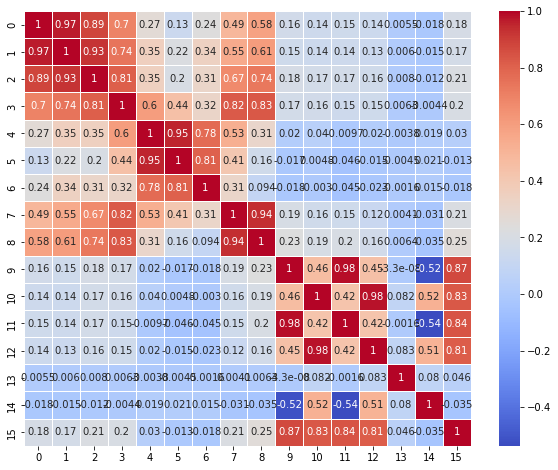

In [22]:
### Visualize correlations between columns of X 
import seaborn as sns
# create a correlation matrix
corr_matrix = np.corrcoef(X_rich, rowvar=False)

# create a larger plot
fig, ax = plt.subplots(figsize=(10, 8))

# create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)

# show plot
plt.show()


In [31]:
##### Runs various models on X and y prepared above 

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# scale X using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_rich = scaler.fit_transform(X_rich)

# Split the data into training and testing sets
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_rich, y.ravel(), test_size=0.2, random_state=42)

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Train the models on the training data
lr.fit(X_2_train, y_2_train)
dt.fit(X_2_train, y_2_train)
rf.fit(X_2_train, y_2_train)
gb.fit(X_2_train, y_2_train)

# Make predictions on the test data
y_2_pred_lr = lr.predict(X_2_test)
y_2_pred_dt = dt.predict(X_2_test)
y_2_pred_rf = rf.predict(X_2_test)
y_2_pred_gb = gb.predict(X_2_test)

# Evaluate the models using mean squared error and R-squared
print("Linear Regression (Sentinel-2 + Sentinel-1 + Indices-1):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_lr)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_lr)))
print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_lr)))
print()

print("Decision Tree (Sentinel-2 + Sentinel-1 + Indices-1):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_dt)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_dt)))
print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_dt)))
print()

print("Random Forest (Sentinel-2 + Sentinel-1 + Indices-1):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_rf)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_rf)))
print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_rf)))
print()

print("Gradient Boosting (Sentinel-2 + Sentinel-1 + Indices-1):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_2_test, y_2_pred_gb)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_2_test, y_2_pred_gb)))
print("R-squared: {:.2f}".format(r2_score(y_2_test, y_2_pred_gb)))
print()


Linear Regression (Sentinel-2 + Sentinel-1 + Indices-1):
Mean Squared Error: 6.82
Mean Absolute Error: 2.20
R-squared: 0.13

Decision Tree (Sentinel-2 + Sentinel-1 + Indices-1):
Mean Squared Error: 12.60
Mean Absolute Error: 2.78
R-squared: -0.60

Random Forest (Sentinel-2 + Sentinel-1 + Indices-1):
Mean Squared Error: 6.40
Mean Absolute Error: 2.09
R-squared: 0.19

Gradient Boosting (Sentinel-2 + Sentinel-1 + Indices-1):
Mean Squared Error: 6.46
Mean Absolute Error: 2.12
R-squared: 0.18



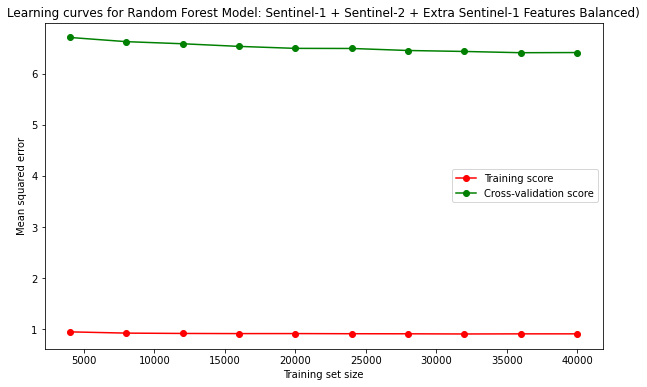

In [21]:
### LESS DATA IN INPUT !!! 10000 rows 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples
subset_idx = np.random.choice(len(X_rich), size= 50000, replace=False)
X_2_subset = X_rich[subset_idx]
y_2_subset = y[subset_idx]

# Create an instance of the Random Forest model
rf_2_model = RandomForestRegressor()

# Define the range of training set sizes to use
train_2_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Random Forest model
train_2_sizes, train_2_scores, test_2_scores = learning_curve(rf_2_model, X_2_subset, y_2_subset, cv=5, train_sizes=train_2_sizes, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train_2_scores = -train_2_scores
test_2_scores = -test_2_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_2_scores_mean = np.mean(train_2_scores, axis=1)
train_2_scores_std = np.std(train_2_scores, axis=1)
test_2_scores_mean = np.mean(test_2_scores, axis=1)
test_2_scores_std = np.std(test_2_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_2_sizes, train_2_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_2_sizes, test_2_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model: Sentinel-1 + Sentinel-2 + Indices-1  Balanced)')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()

## Add also Sentinel-2 indices 

In [38]:
### Add indices inspired by Sentinel-2 

import numpy as np

def generate_X_rich_S2(X):
    # Calculate indices
    NDVI = (X[:,7] - X[:,3]) / (X[:,7] + X[:,3] + np.finfo(float).eps)  #ranked 1
    NDBI = (X[:,11] - X[:,7]) / (X[:,11] + X[:,7] + np.finfo(float).eps)
    NDWI = (X[:,3] - X[:,7]) / (X[:,3] + X[:,7] + np.finfo(float).eps)
    NDSI = (X[:,3] - X[:,11]) / (X[:,3] + X[:,11] + np.finfo(float).eps)
    UAI = (2*X[:,7] - X[:,2] - X[:,1]) / (2*X[:,7] + X[:,2] + X[:,1] + np.finfo(float).eps)  #ranked 1
    
    # Create new numpy array
    X_rich_S2 = np.hstack((X, NDVI.reshape(-1,1), NDBI.reshape(-1,1), NDWI.reshape(-1,1), NDSI.reshape(-1,1), UAI.reshape(-1,1)))
    
    return X_rich_S2


In [39]:
X_rich_S2 = generate_X_rich_S2(X_rich)


print(X_rich_S2.shape)
print(X_rich.shape)
print(X.shape)

(89249, 21)
(89249, 16)
(89249, 11)


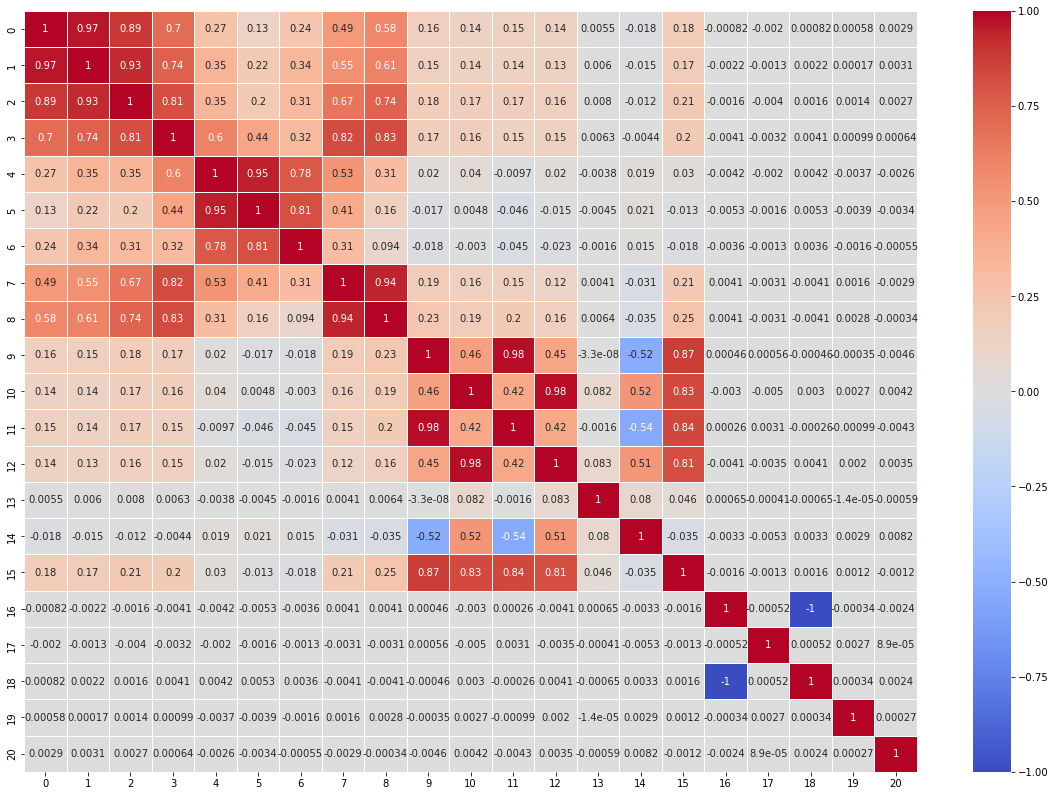

In [41]:
### Visualize correlations between columns of X 
import seaborn as sns
# create a correlation matrix
corr_matrix = np.corrcoef(X_rich_S2, rowvar=False)

# create a larger plot
fig, ax = plt.subplots(figsize=(20, 14))

# create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)

# show plot
plt.show()


In [37]:
##### Runs various models on X and y prepared above 

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# scale X using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_rich_S2 = scaler.fit_transform(X_rich_S2)

# Split the data into training and testing sets
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_rich_S2, y.ravel(), test_size=0.2, random_state=42)

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Train the models on the training data
lr.fit(X_3_train, y_3_train)
dt.fit(X_3_train, y_3_train)
rf.fit(X_3_train, y_3_train)
gb.fit(X_3_train, y_3_train)

# Make predictions on the test data
y_3_pred_lr = lr.predict(X_3_test)
y_3_pred_dt = dt.predict(X_3_test)
y_3_pred_rf = rf.predict(X_3_test)
y_3_pred_gb = gb.predict(X_3_test)

# Evaluate the models using mean squared error and R-squared
print("Linear Regression (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_3_test, y_3_pred_lr)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_3_test, y_3_pred_lr)))
print("R-squared: {:.2f}".format(r2_score(y_3_test, y_3_pred_lr)))
print()

print("Decision Tree (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_3_test, y_3_pred_dt)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_3_test, y_3_pred_dt)))
print("R-squared: {:.2f}".format(r2_score(y_3_test, y_3_pred_dt)))
print()

print("Random Forest (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_3_test, y_3_pred_rf)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_3_test, y_3_pred_rf)))
print("R-squared: {:.2f}".format(r2_score(y_3_test, y_3_pred_rf)))
print()

print("Gradient Boosting (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_3_test, y_3_pred_gb)))
print("Mean Absolute Error: {:.2f}".format(mean_squared_error(y_3_test, y_3_pred_gb)))
print("R-squared: {:.2f}".format(r2_score(y_3_test, y_3_pred_gb)))
print()


Linear Regression (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):
Mean Squared Error: 6.82
Mean Absolute Error: 2.20
R-squared: 0.13

Decision Tree (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):
Mean Squared Error: 12.79
Mean Absolute Error: 2.80
R-squared: -0.62

Random Forest (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):
Mean Squared Error: 6.39
Mean Absolute Error: 2.08
R-squared: 0.19

Gradient Boosting (Sentinel-1 + Sentinel-2 + Indices_1 + Indices_2):
Mean Squared Error: 6.46
Mean Absolute Error: 6.46
R-squared: 0.18



In [43]:
## Grid Search on Linear Regression and Random Forest 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameters and their possible values for Linear Regression and Random Forest
hyperparameters = {
    'LinearRegression': {'normalize': [True, False]},
    'RandomForestRegressor': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
}

# Create a dictionary of the models to be tuned
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

# Loop through the models and their hyperparameters to perform grid search
for model_name, model in models.items():
    hyperparameter_grid = hyperparameters[model_name]
    grid_search = GridSearchCV(model, hyperparameter_grid, cv=5, verbose=2)
    grid_search.fit(X_3_train, y_3_train)
    y_3_pred = grid_search.predict(X_3_test)
    mse = mean_squared_error(y_3_test, y_3_pred)
    mae = mean_absolute_error(y_3_test, y_3_pred)
    r2 = r2_score(y_3_test, y_3_pred)
    print(model_name, "best hyperparameters:", grid_search.best_params_, "MSE:", mse, "MAE:", mae, "R-squared:", r2)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .....................................normalize=True; total time=   0.2s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
LinearRegression best hyperparameters: {'normalize': False} MSE: 6.81792490379876 MAE: 2.2044138509299254 R-squared: 0.13463460183

## Various Features Rankings: RFE and PCA 

In [44]:
### Principal Component Analysis (PCA)

import numpy as np
from sklearn.decomposition import PCA


# Define the number of principal components to keep
n_components_to_keep = 10

# Create the PCA object and fit the data
pca = PCA(n_components=n_components_to_keep)
pca.fit(X_rich_S2)

# Transform the data to the new feature space
X_pca = pca.transform(X_rich_S2)

# Print the explained variance of each principal component
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [6.02866055e-01 2.35705173e-01 1.16122472e-01 4.49079171e-02
 1.44148475e-04 8.97317166e-05 5.33767590e-05 4.95052979e-05
 2.45174211e-05 2.33408284e-05]


In [56]:
# Print the explained variance of each principal component, rounded to 2 decimal places
explained_variance = pca.explained_variance_ratio_
explained_variance_rounded = np.round(explained_variance, 2)
print('Explained variance:', explained_variance_rounded)

# Get the weight matrix for the principal components
weights = np.round(pca.components_,2)
print("Weights:")
print(pd.DataFrame(weights))

# Get the weights for the first principal component
weights_1st = weights[0]
print("List for 1st PC:", np.round(weights_1st,2))

# Sort the weights in descending order
sorted_indices = np.argsort(weights_1st)[::-1]

# Print the names of the top features in the first principal component
feature_names = ['Sentinel-2 B2', 'Sentinel-2 B3', 'Sentinel-2 B4', 'Sentinel-2 B5', 'Sentinel-2 B6', 'Sentinel-2 B7',
                 'Sentinel-2 B8', 'Sentinel-2 B11', 'Sentinel-2 B12', 'Sentinel-1 VV', 'Sentinel-1 VH', 
                 'sigma_VV', 'sigma_VH', 'VH/VV', 'NDVI(VH|VV)', 'UAI(VH|VV)', 
                 'NDVI(Sent-2)', 'NDBI', 'NDWI', 'NDSI', 'UAI(Sent-2)']

print('Top features in the first principal component:')
df = pd.DataFrame({'Feature': feature_names, 'Weight': weights_1st})
df_sorted = df.sort_values('Weight', ascending=False)
print(df_sorted)


Explained variance: [0.6  0.24 0.12 0.04 0.   0.   0.   0.   0.   0.  ]
Weights:
     0     1     2     3     4     5     6     7     8     9   ...    11  \
0  0.00  0.00  0.00  0.00 -0.00 -0.00 -0.00  0.00  0.00 -0.00  ... -0.00   
1 -0.00 -0.00 -0.00 -0.00  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.00   
2 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00  0.00  ...  0.00   
3 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00  0.00  0.00  0.00  ...  0.00   
4  0.32  0.34  0.36  0.37  0.25  0.19  0.18  0.34  0.33  0.18  ...  0.17   
5 -0.08 -0.11 -0.10 -0.14 -0.24 -0.24 -0.23 -0.11 -0.05  0.39  ...  0.39   
6 -0.13 -0.10 -0.11 -0.04  0.21  0.25  0.21 -0.04 -0.12 -0.24  ... -0.26   
7 -0.26 -0.22 -0.23 -0.08  0.39  0.46  0.39 -0.04 -0.20  0.26  ...  0.26   
8  0.01  0.01  0.01 -0.00 -0.00  0.00  0.01 -0.01 -0.01  0.02  ...  0.03   
9  0.42  0.40  0.20 -0.19 -0.05 -0.02  0.29 -0.51 -0.48  0.02  ...  0.04   

     12    13    14    15    16   17    18   19   20  
0  0.00 -0.00  0.00  0.00 -

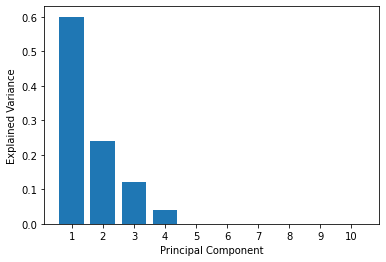

In [57]:
import matplotlib.pyplot as plt

# Plot the explained variance of each principal component
plt.bar(range(1, len(explained_variance_rounded) + 1), explained_variance_rounded)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(range(1, len(explained_variance_rounded) + 1))
plt.show()

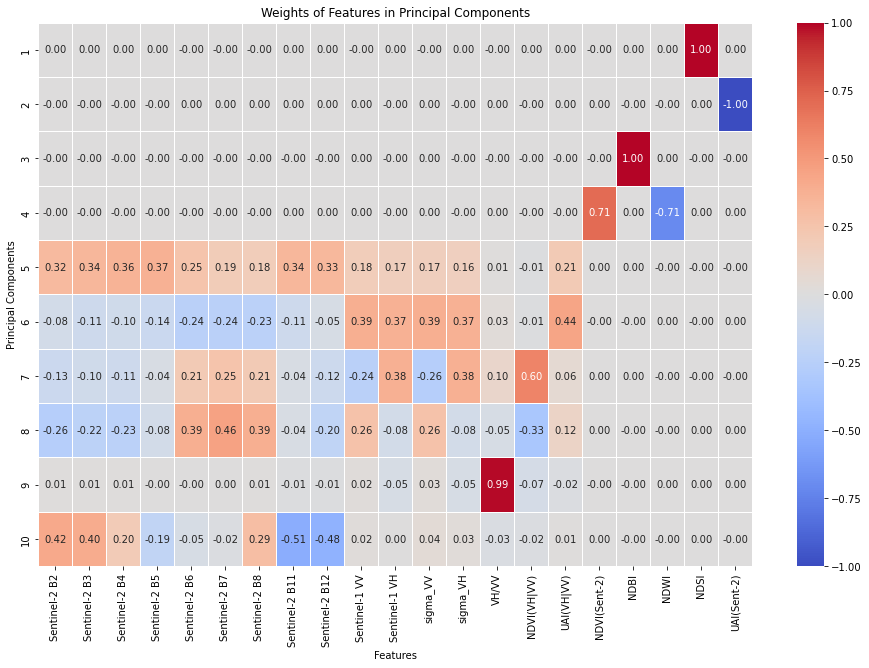

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the weight matrix
plt.figure(figsize=(16, 10))
sns.heatmap(weights, cmap='coolwarm', center=0, annot=True, linewidths=.5, fmt=".2f", xticklabels=feature_names, yticklabels=range(1,11))
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.title('Weights of Features in Principal Components')
plt.show()


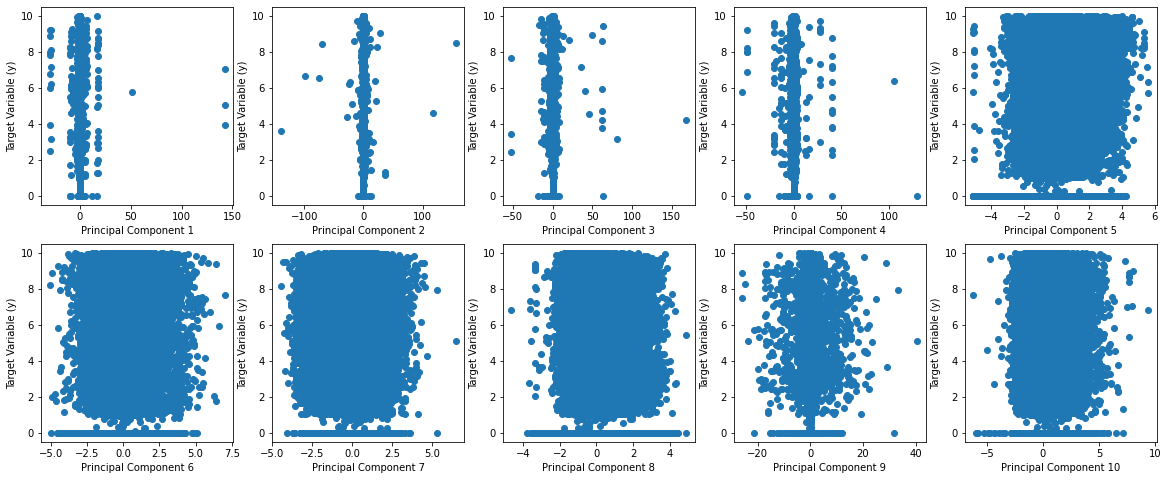

In [69]:
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Loop over the principal components
for i in range(X_pca.shape[1]):
    # Create a scatter plot of the principal component against the target variable
    axs[i].scatter(X_pca[:, i], y)
    
    # Add a label for the x-axis
    axs[i].set_xlabel('Principal Component {}'.format(i+1))
    
    # Add a label for the y-axis
    axs[i].set_ylabel('Target Variable (y)')
    
# Hide the empty subplots
for i in range(X_pca.shape[1], len(axs)):
    axs[i].axis('off')
    
# Show the plot
plt.show()


In [45]:
##### Runs various models on X and y prepared above 

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# scale X using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_pca = scaler.fit_transform(X_pca)

# Split the data into training and testing sets
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_pca, y.ravel(), test_size=0.2, random_state=42)

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Train the models on the training data
lr.fit(X_4_train, y_4_train)
dt.fit(X_4_train, y_4_train)
rf.fit(X_4_train, y_4_train)
gb.fit(X_4_train, y_4_train)

# Make predictions on the test data
y_4_pred_lr = lr.predict(X_4_test)
y_4_pred_dt = dt.predict(X_4_test)
y_4_pred_rf = rf.predict(X_4_test)
y_4_pred_gb = gb.predict(X_4_test)

# Evaluate the models using mean squared error and R-squared
print("Linear Regression (All Sentinels + All Indices + PCA):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_4_test, y_4_pred_lr)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_4_test, y_4_pred_lr)))
print("R-squared: {:.2f}".format(r2_score(y_4_test, y_4_pred_lr)))
print()

print("Decision Tree (All Sentinels + All Indices + PCA):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_4_test, y_4_pred_dt)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_4_test, y_4_pred_dt)))
print("R-squared: {:.2f}".format(r2_score(y_4_test, y_4_pred_dt)))
print()

print("Random Forest (All Sentinels + All Indices + PCA):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_4_test, y_4_pred_rf)))
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_4_test, y_4_pred_rf)))
print("R-squared: {:.2f}".format(r2_score(y_4_test, y_4_pred_rf)))
print()

print("Gradient Boosting (All Sentinels + All Indices + PCA):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_4_test, y_4_pred_gb)))
print("Mean Absolute Error: {:.2f}".format(mean_squared_error(y_4_test, y_4_pred_gb)))
print("R-squared: {:.2f}".format(r2_score(y_4_test, y_4_pred_gb)))
print()


Linear Regression (All Sentinels + All Indices + PCA):
Mean Squared Error: 6.92
Mean Absolute Error: 2.23
R-squared: 0.12

Decision Tree (All Sentinels + All Indices + PCA):
Mean Squared Error: 12.86
Mean Absolute Error: 2.80
R-squared: -0.63

Random Forest (All Sentinels + All Indices + PCA):
Mean Squared Error: 6.59
Mean Absolute Error: 2.13
R-squared: 0.16

Gradient Boosting (All Sentinels + All Indices + PCA):
Mean Squared Error: 6.57
Mean Absolute Error: 6.57
R-squared: 0.17



In [46]:
## Grid Search on Linear Regression and Random Forest 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameters and their possible values for Linear Regression and Random Forest
hyperparameters = {
    'LinearRegression': {'normalize': [True, False]},
    'RandomForestRegressor': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
}

# Create a dictionary of the models to be tuned
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

# Loop through the models and their hyperparameters to perform grid search
for model_name, model in models.items():
    hyperparameter_grid = hyperparameters[model_name]
    grid_search = GridSearchCV(model, hyperparameter_grid, cv=5, verbose=2)
    grid_search.fit(X_4_train, y_4_train)
    y_4_pred = grid_search.predict(X_4_test)
    mse = mean_squared_error(y_4_test, y_4_pred)
    mae = mean_absolute_error(y_4_test, y_4_pred)
    r2 = r2_score(y_4_test, y_4_pred)
    print(model_name, "best hyperparameters:", grid_search.best_params_, "MSE:", mse, "MAE:", mae, "R-squared:", r2)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
LinearRegression best hyperparameters: {'normalize': True} MSE: 6.9198687436732325 MAE: 2.225608492013308 R-squared: 0.12169537577

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


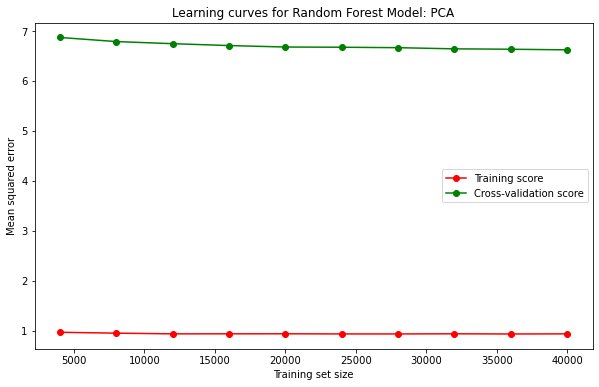

In [64]:
### Learning Curve: Random Forest Regressor with MSE (fewer rows) 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples
subset_idx = np.random.choice(len(X_pca), size= 50000, replace=False)
X_4_subset = X_pca[subset_idx]
y_4_subset = y[subset_idx]

# Create an instance of the Random Forest model
rf_4_model = RandomForestRegressor()

# Define the range of training set sizes to use
train_4_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Random Forest model
train_4_sizes, train_4_scores, test_4_scores = learning_curve(rf_4_model, X_4_subset, y_4_subset, cv=5, train_sizes=train_4_sizes, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train_4_scores = -train_4_scores
test_4_scores = -test_4_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_4_scores_mean = np.mean(train_4_scores, axis=1)
train_4_scores_std = np.std(train_4_scores, axis=1)
test_4_scores_mean = np.mean(test_4_scores, axis=1)
test_4_scores_std = np.std(test_4_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_4_sizes, train_4_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_4_sizes, test_4_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model: PCA')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()

## RFE : Recursive Feature Elimination

In [74]:
#### RFE to improve features selection 
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the number of features to keep
n_features_to_keep = 10

# Create the RFE object and fit the data
model = RandomForestRegressor(random_state=42)
rfe = RFE(model, n_features_to_select=n_features_to_keep)
rfe.fit(X_rich_S2, y)

# Print the ranking of each feature
print('Feature ranking for Random Forest:', rfe.ranking_)

# Obtain the selected features
selected_features = X_rich_S2[:, rfe.support_]

# Create the new feature matrix
X_ref = np.hstack((selected_features, y.reshape(-1, 1)))

# Split the data into training and testing sets
n_samples = X_ref.shape[0]
n_train = int(0.8 * n_samples)
X_train, y_train = X_ref[:n_train, :-1], X_ref[:n_train, -1]
X_test, y_test = X_ref[n_train:, :-1], X_ref[n_train:, -1]

# Fit a random forest regression model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute the mean squared error, mean absolute error, and R2 score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the mean squared error, mean absolute error, and R2 score
print('Mean squared error:', mse)
print('Mean absolute error:', mae)
print('R2 score:', r2)

Feature ranking for Random Forest: [ 1  5  3  8  4  1  1  6  1 12  7  9 11  2  1  1 10  1  1  1  1]
Mean squared error: 6.320925631753819
Mean absolute error: 2.0673567179120114
R2 score: 0.18714028583093867


In [75]:
print("Here's the most important features:")
for i, rank in enumerate(rfe.ranking_):
    print(f"{feature_names[i]}: {rank}")

Here's the most important features:
Sentinel-2 B2: 1
Sentinel-2 B3: 5
Sentinel-2 B4: 3
Sentinel-2 B5: 8
Sentinel-2 B6: 4
Sentinel-2 B7: 1
Sentinel-2 B8: 1
Sentinel-2 B11: 6
Sentinel-2 B12: 1
Sentinel-1 VV: 12
Sentinel-1 VH: 7
sigma_VV: 9
sigma_VH: 11
VH/VV: 2
NDVI(VH|VV): 1
UAI(VH|VV): 1
NDVI(Sent-2): 10
NDBI: 1
NDWI: 1
NDSI: 1
UAI(Sent-2): 1


/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


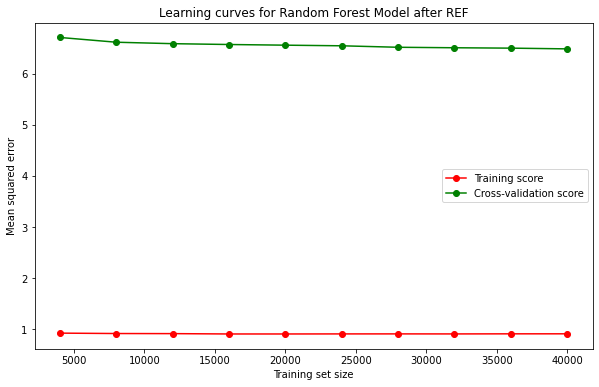

In [76]:
## Learning Curve for MSE (Random Forest with standard parameters) on X_ref 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples
subset_idx = np.random.choice(len(X_ref), size= 50000, replace=False)
X_4_subset = X_ref[subset_idx, :-1]
y_4_subset = y[subset_idx]

# Create an instance of the Random Forest model
rf_4_model = RandomForestRegressor()

# Define the range of training set sizes to use
train_4_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Random Forest model
train_4_sizes, train_4_scores, test_4_scores = learning_curve(rf_4_model, X_4_subset, y_4_subset, cv=5, train_sizes=train_4_sizes, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train_4_scores = -train_4_scores
test_4_scores = -test_4_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_4_scores_mean = np.mean(train_4_scores, axis=1)
train_4_scores_std = np.std(train_4_scores, axis=1)
test_4_scores_mean = np.mean(test_4_scores, axis=1)
test_4_scores_std = np.std(test_4_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_4_sizes, train_4_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_4_sizes, test_4_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model after REF')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()

In [77]:
## Grid Search on Linear Regression and Random Forest 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameters and their possible values for Linear Regression and Random Forest
hyperparameters = {
    'LinearRegression': {'normalize': [True, False]},
    'RandomForestRegressor': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
}

# Create a dictionary of the models to be tuned
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

# Loop through the models and their hyperparameters to perform grid search
for model_name, model in models.items():
    hyperparameter_grid = hyperparameters[model_name]
    grid_search = GridSearchCV(model, hyperparameter_grid, cv=5, verbose=2)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(model_name, "best hyperparameters:", grid_search.best_params_, "MSE:", mse, "MAE:", mae, "R-squared:", r2)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
LinearRegression best hyperparameters: {'normalize': True} MSE: 6.708916924140226 MAE: 2.1866920126400458 R-squared: 0.13724530060

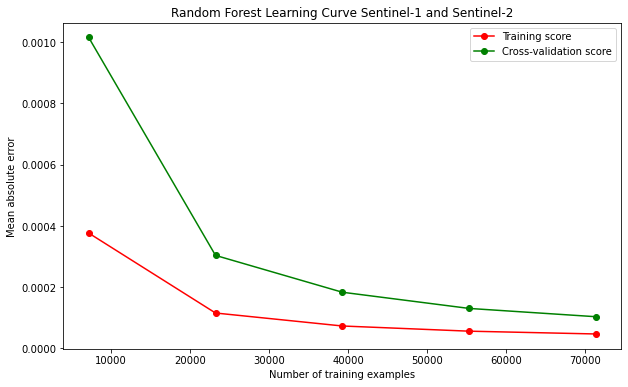

In [81]:
## Learning Curve for MAE (optimal Random Forest Model on X_ref): 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the best hyperparameters
params = {'max_depth': 15, 'n_estimators': 300}

# Create an instance of the Random Forest model with the best hyperparameters
rf_model = RandomForestRegressor(**params)

# Calculate the learning curve
train_5_sizes, train_5_scores, test_5_scores = learning_curve(rf_model, X_ref, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_5_scores_mean = -np.mean(train_5_scores, axis=1)
train_5_scores_std = np.std(train_5_scores, axis=1)
test_5_scores_mean = -np.mean(test_5_scores, axis=1)
test_5_scores_std = np.std(test_5_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_5_sizes, train_5_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_5_sizes, test_5_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Number of training examples')
plt.ylabel('Mean absolute error')
plt.title('Random Forest Learning Curve Sentinel-1 and Sentinel-2') 
plt.legend()
plt.show()

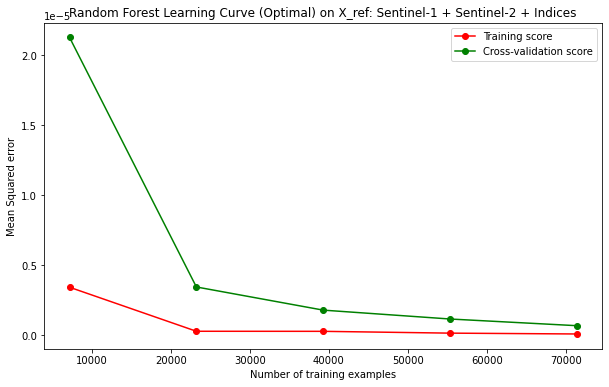

In [82]:
## Learning curve for MSE (optimal Random Forest model on X_ref)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the best hyperparameters
params = {'max_depth': 15, 'n_estimators': 300}

# Create an instance of the Random Forest model with the best hyperparameters
rf_model = RandomForestRegressor(**params)

# Calculate the learning curve
train_6_sizes, train_6_scores, test_6_scores = learning_curve(rf_model, X_ref, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_6_scores_mean = -np.mean(train_6_scores, axis=1)
train_6_scores_std = np.std(train_6_scores, axis=1)
test_6_scores_mean = -np.mean(test_6_scores, axis=1)
test_6_scores_std = np.std(test_6_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_6_sizes, train_6_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_6_sizes, test_6_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Number of training examples')
plt.ylabel('Mean Squared error')
plt.title('Random Forest Learning Curve (Optimal) on X_ref: Sentinel-1 + Sentinel-2 + Indices') 
plt.legend()
plt.show()